# Align Visium Data and Annotate ROIs

In [1]:
import scanpy as sc
import squidpy as sq
import spatialdata as sd
import spatialdata_io as si
import numpy as np
import pandas as pd
from anndata import AnnData
import pathlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import skimage
import seaborn as sns
from spatialdata.models import ShapesModel
import spatialdata_plot
import cv2
from napari_spatialdata import Interactive
from spatialdata.transformations import (
    Affine,
    Identity,
    MapAxis,
    Scale,
    Sequence,
    Translation,
    get_transformation,
    get_transformation_between_coordinate_systems,
    set_transformation,
)
from spatialdata.models import ShapesModel
from spatialdata.transformations import (
    align_elements_using_landmarks,
    get_transformation_between_landmarks,
)
from spatialdata import SpatialData
from spatialdata.transformations import (
    BaseTransformation,
    Sequence,
    get_transformation,
    set_transformation,
)

❗ You are running 3.11.3
Only python versions 3.7~3.10 are currently tested, use at your own risk.


In [2]:
import warnings
warnings.filterwarnings('ignore')

INFO     reading /Users/lucast3/Documents/VisiumAnalysis/LIB5472833_SAM24434294/outs/filtered_feature_bc_matrix.h5 
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           
INFO     reading /Users/lucast3/Documents/VisiumAnalysis/LIB5472834_SAM24434295/outs/filtered_feature_bc_matrix.h5 
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           
INFO     reading /Users/lucast3/Documents/VisiumAnalysis/LIB5472835_SAM24434296/outs/filtered_feature_bc_matrix.h5 
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           
INFO     reading /Users/lucast3/Documents/VisiumAnalysis/LIB5472836_SAM24434297/outs/filtered_feature_bc_matrix.h5 
INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           
INFO     reading /Users/lucast3/Documents/VisiumAnalysis/LIB5472837_SAM2

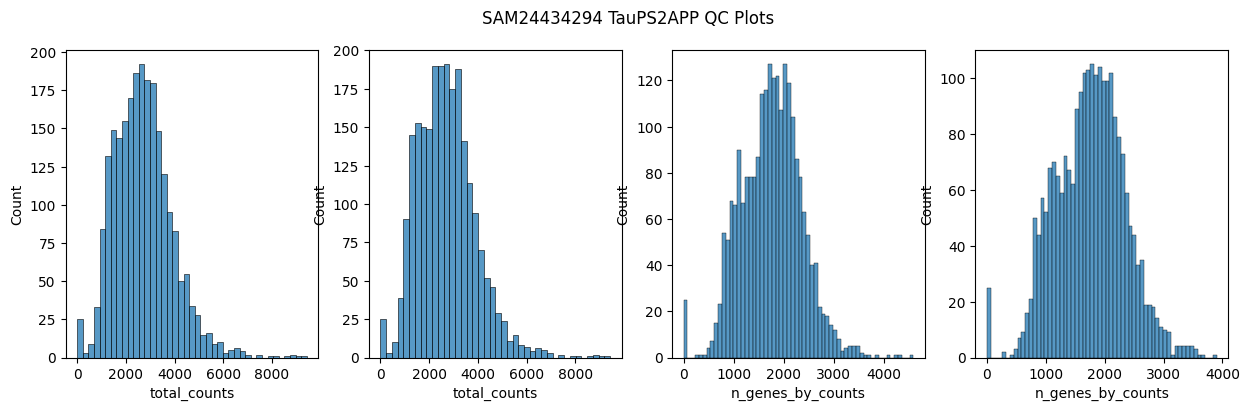

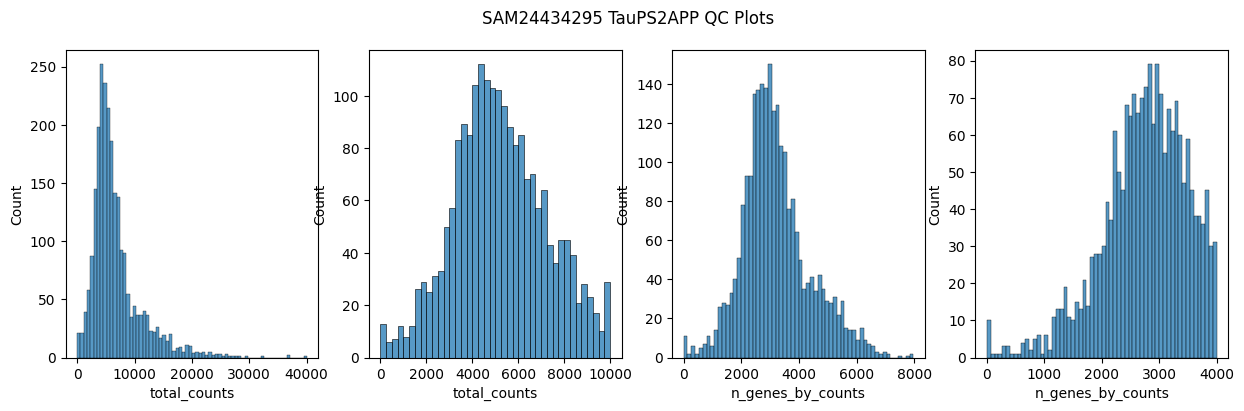

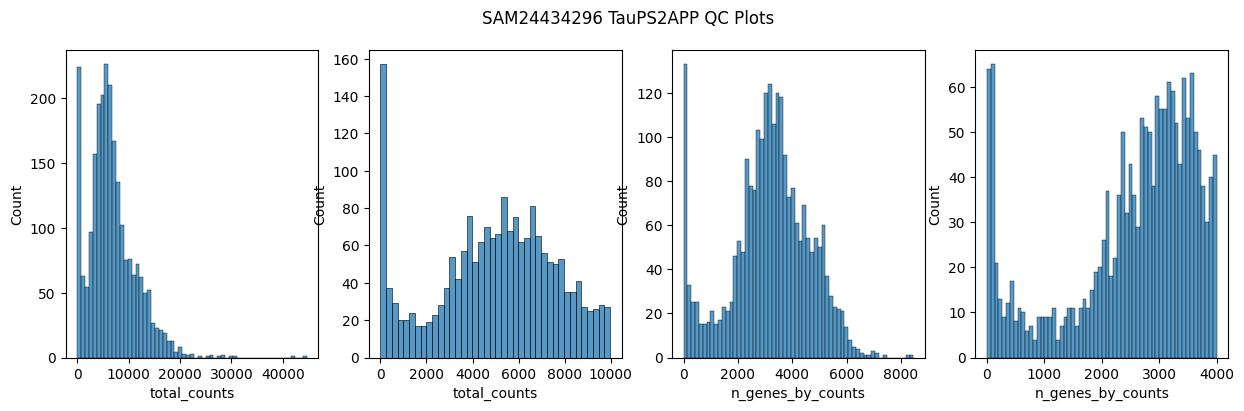

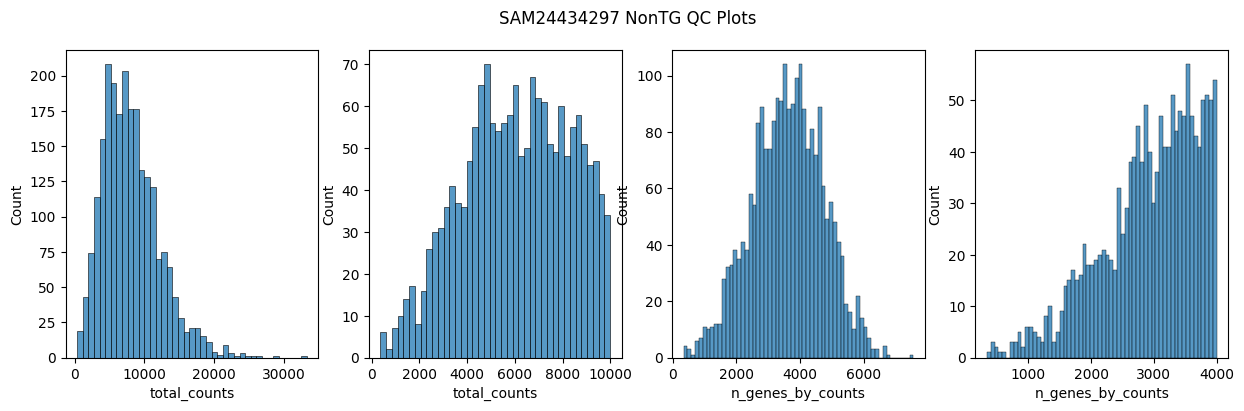

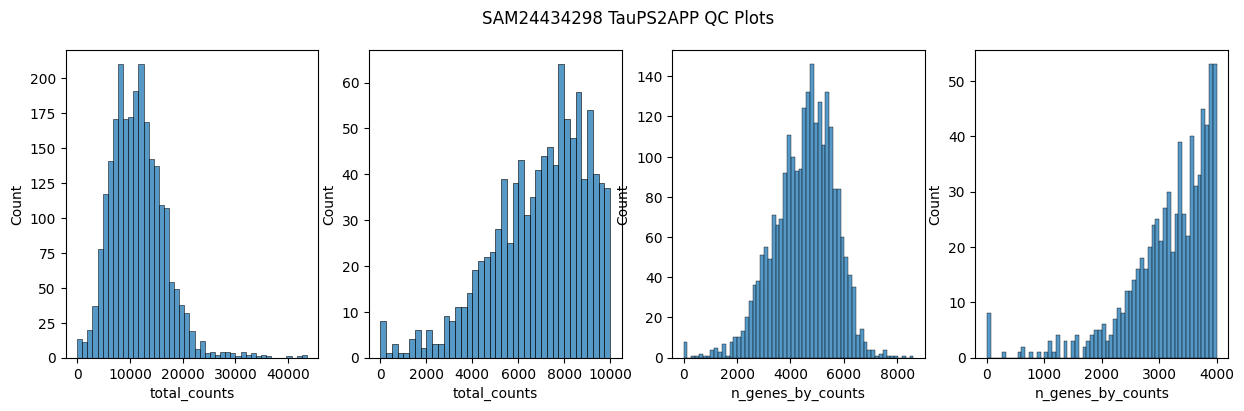

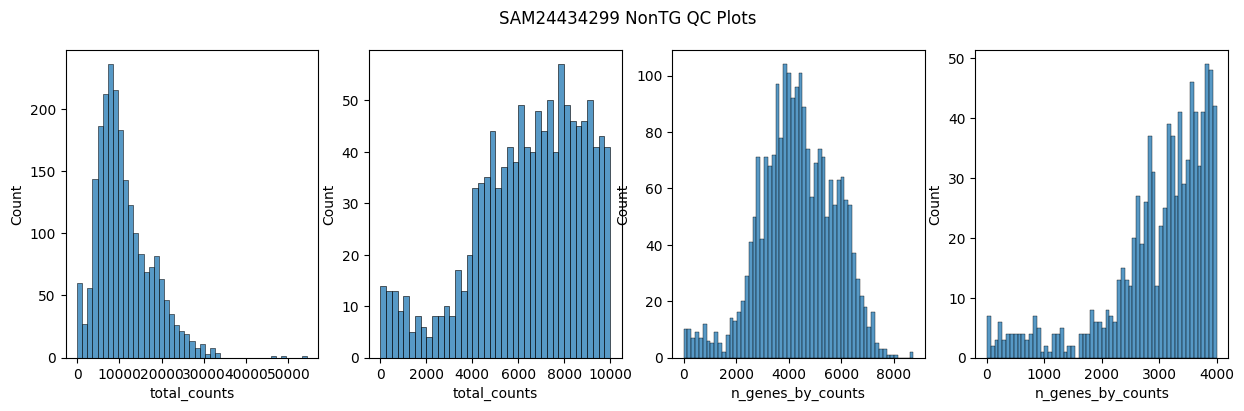

In [10]:
# list of datasets
datasets = ['LIB5472833_SAM24434294','LIB5472834_SAM24434295', 'LIB5472835_SAM24434296',
            'LIB5472836_SAM24434297','LIB5472837_SAM24434298','LIB5472838_SAM24434299']
condition = ['TauPS2APP','TauPS2APP','TauPS2APP','NonTG','TauPS2APP','NonTG']

# initialize an empty list to store all the spatial data objects
data_list = []

# loop through each dataset adding Abeta image, metadata, and process spots using standard pipeline
for dataset,cond in zip(datasets,condition):
    # read in data into a spatial data object
    data = si.visium(path=f'/Users/lucast3/Documents/VisiumAnalysis/{dataset}/outs/',
                     dataset_id=dataset,
                     tissue_positions_file='spatial/tissue_positions.csv',
                     scalefactors_file='spatial/scalefactors_json.json')
    #read in pathology image
    im = cv2.imread(f'/Users/lucast3/Documents/VisiumAnalysis/ABeta/{dataset.split("_")[0]}.png')
    
    #Parse
    img_sd = sd.models.Image2DModel.parse(im,
                                  dims=("y","x","c"))
    #Add to object
    data.images["AB"]= img_sd
    
    #Transform
    scale = Scale([0.6666667,0.6666667], axes=("y","x"))
    set_transformation(data.images["AB"],scale,to_coordinate_system="downscaled_hires")
    
    #Add Metadata
    data.table.obs['Condition'] = cond
    data.table.obs['Sample'] = dataset.split("_")[1]
    data.table.layers['counts']=data.table.X.copy()
    
    # Process using Expression 
    sc.pp.calculate_qc_metrics(data.table, inplace=True)
    
    #Plot QC
    fig, axs = plt.subplots(1, 4, figsize=(15, 4))
    sns.histplot(data.table.obs["total_counts"], kde=False, ax=axs[0])
    sns.histplot(data.table.obs["total_counts"][data.table.obs["total_counts"] < 10000], kde=False, bins=40, ax=axs[1])
    sns.histplot(data.table.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
    sns.histplot(data.table.obs["n_genes_by_counts"][data.table.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])
    fig.suptitle(' '.join([dataset.split("_")[1],cond,'QC Plots']))
    
    #Run Standard processing pipeline
    sc.pp.normalize_total(data.table, inplace=True)
    sc.pp.log1p(data.table)
    sc.pp.highly_variable_genes(data.table, flavor="seurat", n_top_genes=2000)
    sc.pp.pca(data.table)
    sc.pp.neighbors(data.table)
    sc.tl.umap(data.table)
    sc.tl.leiden(data.table, key_added="clusters")
    data.table.layers['logcounts'] = data.table.X.copy()
    
    # append the data to the list
    data_list.append(data)

## LIB5472833_SAM24434294 Alignment and ROI annotation

Annotate the landmarks to align Abeta and Visium image

In [6]:
Interactive(data_list[0])

<2336x19465 sparse matrix of type '<class 'numpy.float32'>'
	with 4103289 stored elements in Compressed Sparse Row format>

In [8]:
affine = get_transformation_between_landmarks(
    references_coords=data_list[0]["AbetaLandmarks"], moving_coords=data_list[0]["VisiumLandmarks"]
)
affine1 = align_elements_using_landmarks(
    moving_coords=data_list[0]["VisiumLandmarks"],
    references_coords=data_list[0]["AbetaLandmarks"],
    moving_element=data_list[0]["LIB5472833_SAM24434294_hires_image"],
    reference_element=data_list[0]["AB"],
    reference_coordinate_system="global",
    moving_coordinate_system="downscaled_hires",
    new_coordinate_system="aligned",
)

In [9]:
sequence = Sequence([scale, affine])
set_transformation(data_list[0].shapes['LIB5472833_SAM24434294'],sequence,to_coordinate_system="aligned")

sequence = Sequence([get_transformation(data_list[0].points["AbetaLandmarks"],get_all=True)['global'], affine])
set_transformation(data_list[0].points["AbetaLandmarks"],sequence,to_coordinate_system="aligned")

sequence = Sequence([get_transformation(data_list[0].points["VisiumLandmarks"],get_all=True)['downscaled_hires'], affine])
set_transformation(data_list[0].points["VisiumLandmarks"],sequence,to_coordinate_system="aligned")


Now let's go ahead and mark the ROIs. Mark the Cortex and Hippocampus in the Downscaled coordinate system and the pathology in the global coordinate system

In [12]:
Interactive(data_list[0])

In [11]:
sequence = Sequence([get_transformation(data_list[0].images["LIB5472833_SAM24434294_hires_image"],get_all=True)['downscaled_hires'], affine])
set_transformation(data_list[0].shapes['Hippocampus'],sequence,to_coordinate_system="aligned")
set_transformation(data_list[0].shapes['Cortex'],sequence,to_coordinate_system="aligned")


In [ ]:
data_list[0].write(f'/Users/lucast3/Documents/VisiumAnalysis/data/LIB5472833_SAM24434294.zarr')

## LIB5472834_SAM24434295 Alignment and ROI Annotation

In [49]:
Interactive(data_list[1])

In [50]:
affine = get_transformation_between_landmarks(
    references_coords=data_list[1]["AbetaLandmarks"], moving_coords=data_list[1]["VisiumLandmarks"]
)
affine1 = align_elements_using_landmarks(
    moving_coords=data_list[1]["VisiumLandmarks"],
    references_coords=data_list[1]["AbetaLandmarks"],
    moving_element=data_list[1]["LIB5472834_SAM24434295_hires_image"],
    reference_element=data_list[1]["AB"],
    reference_coordinate_system="global",
    moving_coordinate_system="downscaled_hires",
    new_coordinate_system="aligned",
)

In [51]:
sequence = Sequence([scale, affine])
set_transformation(data_list[1].shapes['LIB5472834_SAM24434295'],sequence,to_coordinate_system="aligned")

sequence = Sequence([get_transformation(data_list[1].points["AbetaLandmarks"],get_all=True)['global'], affine])
set_transformation(data_list[1].points["AbetaLandmarks"],sequence,to_coordinate_system="aligned")

sequence = Sequence([get_transformation(data_list[1].points["VisiumLandmarks"],get_all=True)['downscaled_hires'], affine])
set_transformation(data_list[1].points["VisiumLandmarks"],sequence,to_coordinate_system="aligned")


Now let's go ahead and mark the ROIs. Mark the Cortex and Hippocampus in the Downscaled coordinate system and the pathology in the global coordinate system

In [53]:
Interactive(data_list[1])

In [30]:
sequence = Sequence([get_transformation(data_list[1].images["LIB5472834_SAM24434295_hires_image"],get_all=True)['downscaled_hires'], affine])
set_transformation(data_list[1].shapes['Hippocampus'],sequence,to_coordinate_system="aligned")
set_transformation(data_list[1].shapes['Cortex'],sequence,to_coordinate_system="aligned")

## LIB5472835_SAM24434296 Alignments and ROI Annotation

In [21]:
Interactive(data_list[2])

In [22]:
affine = get_transformation_between_landmarks(
    references_coords=data_list[2]["AbetaLandmarks"], moving_coords=data_list[2]["VisiumLandmarks"]
)
affine1 = align_elements_using_landmarks(
    moving_coords=data_list[2]["VisiumLandmarks"],
    references_coords=data_list[2]["AbetaLandmarks"],
    moving_element=data_list[2]["LIB5472835_SAM24434296_hires_image"],
    reference_element=data_list[2]["AB"],
    reference_coordinate_system="global",
    moving_coordinate_system="downscaled_hires",
    new_coordinate_system="aligned",
)

In [23]:
sequence = Sequence([scale, affine])
set_transformation(data_list[2].shapes['LIB5472835_SAM24434296'],sequence,to_coordinate_system="aligned")

sequence = Sequence([get_transformation(data_list[2].points["AbetaLandmarks"],get_all=True)['global'], affine])
set_transformation(data_list[2].points["AbetaLandmarks"],sequence,to_coordinate_system="aligned")

sequence = Sequence([get_transformation(data_list[2].points["VisiumLandmarks"],get_all=True)['downscaled_hires'], affine])
set_transformation(data_list[2].points["VisiumLandmarks"],sequence,to_coordinate_system="aligned")


Now let's go ahead and mark the ROIs. Mark the Cortex and Hippocampus in the Downscaled coordinate system and the pathology in the global coordinate system

In [27]:
Interactive(data_list[2])

In [25]:
sequence = Sequence([get_transformation(data_list[2].images["LIB5472835_SAM24434296_hires_image"],get_all=True)['downscaled_hires'], affine])
set_transformation(data_list[2].shapes['Hippocampus'],sequence,to_coordinate_system="aligned")
set_transformation(data_list[2].shapes['Cortex'],sequence,to_coordinate_system="aligned")


## LIB5472836_SAM24434297 Alignment and ROI Annotation

In [26]:
Interactive(data_list[3])

In [28]:
affine = get_transformation_between_landmarks(
    references_coords=data_list[3]["AbetaLandmarks"], moving_coords=data_list[3]["VisiumLandmarks"]
)
affine1 = align_elements_using_landmarks(
    moving_coords=data_list[3]["VisiumLandmarks"],
    references_coords=data_list[3]["AbetaLandmarks"],
    moving_element=data_list[3]["LIB5472836_SAM24434297_hires_image"],
    reference_element=data_list[3]["AB"],
    reference_coordinate_system="global",
    moving_coordinate_system="downscaled_hires",
    new_coordinate_system="aligned",
)

In [29]:
sequence = Sequence([scale, affine])
set_transformation(data_list[3].shapes['LIB5472836_SAM24434297'],sequence,to_coordinate_system="aligned")

sequence = Sequence([get_transformation(data_list[3].points["AbetaLandmarks"],get_all=True)['global'], affine])
set_transformation(data_list[3].points["AbetaLandmarks"],sequence,to_coordinate_system="aligned")

sequence = Sequence([get_transformation(data_list[3].points["VisiumLandmarks"],get_all=True)['downscaled_hires'], affine])
set_transformation(data_list[3].points["VisiumLandmarks"],sequence,to_coordinate_system="aligned")


Now let's go ahead and mark the ROIs. Mark the Cortex and Hippocampus in the Downscaled coordinate system and the pathology in the global coordinate system

In [30]:
Interactive(data_list[3])

In [31]:
sequence = Sequence([get_transformation(data_list[3].images["LIB5472836_SAM24434297_hires_image"],get_all=True)['downscaled_hires'], affine])
set_transformation(data_list[3].shapes['Hippocampus'],sequence,to_coordinate_system="aligned")
set_transformation(data_list[3].shapes['Cortex'],sequence,to_coordinate_system="aligned")


## LIB5472837_SAM24434298 Alignment and ROI Annotation

In [32]:
Interactive(data_list[4])

In [33]:
affine = get_transformation_between_landmarks(
    references_coords=data_list[4]["AbetaLandmarks"], moving_coords=data_list[4]["VisiumLandmarks"]
)
affine1 = align_elements_using_landmarks(
    moving_coords=data_list[4]["VisiumLandmarks"],
    references_coords=data_list[4]["AbetaLandmarks"],
    moving_element=data_list[4]["LIB5472837_SAM24434298_hires_image"],
    reference_element=data_list[4]["AB"],
    reference_coordinate_system="global",
    moving_coordinate_system="downscaled_hires",
    new_coordinate_system="aligned",
)

In [34]:
sequence = Sequence([scale, affine])
set_transformation(data_list[4].shapes['LIB5472837_SAM24434298'],sequence,to_coordinate_system="aligned")

sequence = Sequence([get_transformation(data_list[4].points["AbetaLandmarks"],get_all=True)['global'], affine])
set_transformation(data_list[4].points["AbetaLandmarks"],sequence,to_coordinate_system="aligned")

sequence = Sequence([get_transformation(data_list[4].points["VisiumLandmarks"],get_all=True)['downscaled_hires'], affine])
set_transformation(data_list[4].points["VisiumLandmarks"],sequence,to_coordinate_system="aligned")


Now let's go ahead and mark the ROIs. Mark the Cortex and Hippocampus in the Downscaled coordinate system and the pathology in the global coordinate system

In [40]:
Interactive(data_list[4])

In [39]:
sequence = Sequence([get_transformation(data_list[4].images["LIB5472837_SAM24434298_hires_image"],get_all=True)['downscaled_hires'], affine])
set_transformation(data_list[4].shapes['Hippocampus'],sequence,to_coordinate_system="aligned")
set_transformation(data_list[4].shapes['Cortex'],sequence,to_coordinate_system="aligned")


## LIB5472838_SAM24434299 Alignment and ROI Annotation

In [9]:
Interactive(data_list[5])

Traceback (most recent call last):
  File "/Users/lucast3/.pyenv/versions/3.11.3/lib/python3.11/site-packages/napari/_qt/widgets/qt_viewer_dock_widget.py", line 230, in keyPressEvent
    return self._ref_qt_viewer().keyPressEvent(event)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/lucast3/.pyenv/versions/3.11.3/lib/python3.11/site-packages/napari/_qt/qt_viewer.py", line 1263, in keyPressEvent
    self.canvas._backend._keyEvent(self.canvas.events.key_press, event)
  File "/Users/lucast3/.pyenv/versions/3.11.3/lib/python3.11/site-packages/vispy/app/backends/_qt.py", line 647, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/Users/lucast3/.pyenv/versions/3.11.3/lib/python3.11/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/Users/lucast3/.pyenv/versions/3.11.3/lib/python3.11/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_

In [10]:
data_list[5]

SpatialData object with:
├── Images
│     ├── 'AB': SpatialImage[cyx] (3, 3578, 4525)
│     ├── 'LIB5472838_SAM24434299_hires_image': SpatialImage[cyx] (3, 2000, 2000)
│     └── 'LIB5472838_SAM24434299_lowres_image': SpatialImage[cyx] (3, 600, 600)
├── Points
│     ├── 'AbetaLandmarks': DataFrame with shape: (<Delayed>, 2) (2D points)
│     └── 'VisiumLandmarks': DataFrame with shape: (<Delayed>, 2) (2D points)
├── Shapes
│     └── 'LIB5472838_SAM24434299': GeoDataFrame shape: (2252, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 2252 × 19465
    obs: 'in_tissue', 'array_row', 'array_col', 'spot_id', 'region', 'Condition', 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_drop

In [11]:
affine = get_transformation_between_landmarks(
    references_coords=data_list[5]["AbetaLandmarks"], moving_coords=data_list[5]["VisiumLandmarks"]
)
affine1 = align_elements_using_landmarks(
    moving_coords=data_list[5]["VisiumLandmarks"],
    references_coords=data_list[5]["AbetaLandmarks"],
    moving_element=data_list[5]["LIB5472838_SAM24434299_hires_image"],
    reference_element=data_list[5]["AB"],
    reference_coordinate_system="global",
    moving_coordinate_system="downscaled_hires",
    new_coordinate_system="aligned",
)

In [12]:
sequence = Sequence([scale, affine])
set_transformation(data_list[5].shapes['LIB5472838_SAM24434299'],sequence,to_coordinate_system="aligned")

sequence = Sequence([get_transformation(data_list[5].points["AbetaLandmarks"],get_all=True)['global'], affine])
set_transformation(data_list[5].points["AbetaLandmarks"],sequence,to_coordinate_system="aligned")

sequence = Sequence([get_transformation(data_list[5].points["VisiumLandmarks"],get_all=True)['downscaled_hires'], affine])
set_transformation(data_list[5].points["VisiumLandmarks"],sequence,to_coordinate_system="aligned")


In [14]:
data = data_list[5]

Now let's go ahead and mark the ROIs. Mark the Cortex and Hippocampus in the Downscaled coordinate system and the pathology in the global coordinate system

In [17]:
Interactive(data_list[5])

In [16]:
sequence = Sequence([get_transformation(data_list[5].images["LIB5472838_SAM24434299_hires_image"],get_all=True)['downscaled_hires'], affine])
set_transformation(data_list[5].shapes['Hippocampus'],sequence,to_coordinate_system="aligned")
set_transformation(data_list[5].shapes['Cortex'],sequence,to_coordinate_system="aligned")


# Final Save

In [58]:
# final Save
from spatialdata import save_transformations
x=0
for dataset in datasets:
    data_list[x].write(f'/Users/lucast3/Documents/VisiumAnalysis/data/{dataset}.zarr')
    save_transformations(data_list[x])
    x=x+1

In [20]:
x=5
data_list[x].write(f'/Users/lucast3/Documents/VisiumAnalysis/data/{dataset}.zarr')
save_transformations(data_list[x])

NameError: name 'save_transformations' is not defined

In [23]:
# Write spot data to h5ad object so we can export to Seurat and scanpy later
x=0
for dataset in datasets:
    data_list[x].table.write_h5ad(f'/Users/lucast3/Documents/VisiumAnalysis/data/{dataset}_Spots.h5ad')
    x=x+1